# **Análisis de Variables Numéricas y Correlación Estadística 📊**

En este notebook realizaremos el cierre de la fase de Análisis Exploratorio de Datos (EDA). Nos enfocaremos en validar la distribución de las variables continuas y su relación con las variables clínicas binarias.

**Objetivos:**
1. **Validación de Normalidad:** Aplicar la prueba de Shapiro-Wilk.
2. **Análisis de Outliers:** Identificar casos clínicos atípicos mediante el método IQR.
3. **Binarización Estratégica:** Transformar variables categóricas clave (`Residence_type`).
4. **Matriz de Correlación:** Evaluar la relación entre variables y su significancia estadística (P-values).

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis, shapiro, pearsonr

# 1. Carga del dataset
df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')

# 2. Binarización explícita de Residencia (1: Urbano, 0: Rural)
df['Residence_type_bin'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

# 3. Asegurar tipos de datos para las variables binarias y clínicas
cols_clinicas = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'Residence_type_bin', 'stroke']
df_analysis = df[cols_clinicas].dropna()

# Convertir binarias a int para evitar problemas en cálculos
for col in ['hypertension', 'heart_disease', 'Residence_type_bin', 'stroke']:
    df_analysis[col] = df_analysis[col].astype(int)

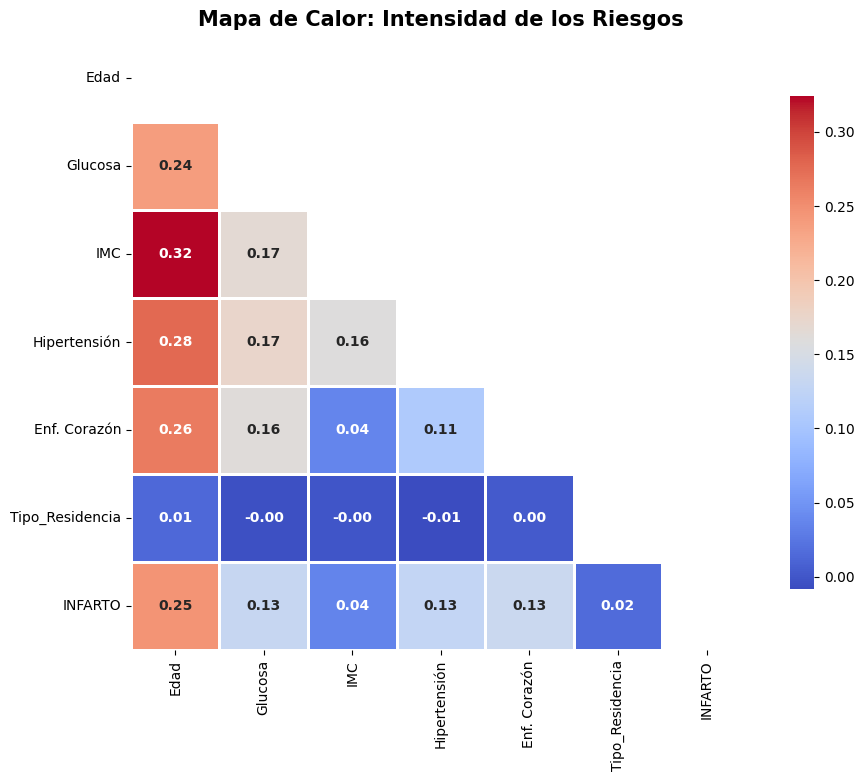


¿QUÉ RELACIONES SON REALES Y CUÁLES SON RUIDO ESTADÍSTICO?


C:\Users\delhy.py\AppData\Local\Temp\ipykernel_16108\785373029.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(p_vals.style.applymap(lambda x: style_sig(x)).format(lambda x: "REAL" if x < 0.05 else "RUIDO"))


,Edad,Glucosa,IMC,Hipertensión,Enf. Corazón,Tipo_Residencia,INFARTO
Edad,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL
Glucosa,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL
IMC,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL
Hipertensión,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL
Enf. Corazón,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL
Tipo_Residencia,RUIDO,RUIDO,RUIDO,RUIDO,RUIDO,REAL,RUIDO
INFARTO,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL


In [3]:
# Función para matriz de P-values
def get_p_matrix(data):
    p_matrix = pd.DataFrame(index=data.columns, columns=data.columns)
    for r in data.columns:
        for c in data.columns:
            p_matrix.loc[r, c] = pearsonr(data[r], data[c])[1] if r != c else 0.0
    return p_matrix.astype(float)

# Nombres amigables para el Hospital
nombres_es = {
    'age': 'Edad', 'avg_glucose_level': 'Glucosa', 'bmi': 'IMC',
    'hypertension': 'Hipertensión', 'heart_disease': 'Enf. Corazón',
    'Residence_type_bin': 'Tipo_Residencia', 'stroke': 'INFARTO'
}

df_visual = df_analysis.rename(columns=nombres_es)
corr_matrix = df_visual.corr()
p_vals = get_p_matrix(df_visual)

# --- GRÁFICO 1: HEATMAP ---
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=1, cbar_kws={"shrink": .8}, annot_kws={"weight": "bold"})
plt.title('Mapa de Calor: Intensidad de los Riesgos', fontsize=15, fontweight='bold')
plt.show()

# --- GRÁFICO 2: TABLA DE SIGNIFICANCIA (EL FILTRO) ---
def style_sig(val):
    color = '#27ae60' if val < 0.05 else '#c0392b' # Verde Real / Rojo Ruido
    return f'background-color: {color}; color: white; font-weight: bold; text-align: center'

print("\n" + "="*60)
print("¿QUÉ RELACIONES SON REALES Y CUÁLES SON RUIDO ESTADÍSTICO?")
print("="*60)
display(p_vals.style.applymap(lambda x: style_sig(x)).format(lambda x: "REAL" if x < 0.05 else "RUIDO"))

In [4]:
# 1. Definir el umbral de Bonferroni
num_variables = len(df_visual.columns)
# El número de comparaciones únicas en una matriz (sin contar la diagonal) es (n*(n-1))/2
num_comparaciones = (num_variables * (num_variables - 1)) / 2
alpha_original = 0.05
alpha_bonferroni = alpha_original / num_comparaciones

print(f"Número de variables: {num_variables}")
print(f"Número de comparaciones: {int(num_comparaciones)}")
print(f"Umbral original (alpha): {alpha_original}")
print(f"NUEVO Umbral de Bonferroni: {alpha_bonferroni:.4f}")

# 2. Función de estilo actualizada para Bonferroni
def style_bonferroni(val):
    # Solo es REAL si es menor al nuevo umbral ajustado
    color = '#27ae60' if val < alpha_bonferroni else '#c0392b' 
    return f'background-color: {color}; color: white; font-weight: bold; text-align: center'

# 3. Mostrar la tabla con el nuevo filtro exigente
print("\n" + "="*70)
print("FILTRO DE BONFERRONI: ¿Qué relaciones son ULTRA-ROBUSTAS?")
print("="*70)
display(p_vals.style.applymap(style_bonferroni).format(lambda x: "REAL" if x < alpha_bonferroni else "RUIDO"))

Número de variables: 7
Número de comparaciones: 21
Umbral original (alpha): 0.05
NUEVO Umbral de Bonferroni: 0.0024

FILTRO DE BONFERRONI: ¿Qué relaciones son ULTRA-ROBUSTAS?


C:\Users\delhy.py\AppData\Local\Temp\ipykernel_16108\149523865.py:23: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(p_vals.style.applymap(style_bonferroni).format(lambda x: "REAL" if x < alpha_bonferroni else "RUIDO"))


,Edad,Glucosa,IMC,Hipertensión,Enf. Corazón,Tipo_Residencia,INFARTO
Edad,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL
Glucosa,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL
IMC,REAL,REAL,REAL,REAL,RUIDO,RUIDO,RUIDO
Hipertensión,REAL,REAL,REAL,REAL,REAL,RUIDO,REAL
Enf. Corazón,REAL,REAL,RUIDO,REAL,REAL,RUIDO,REAL
Tipo_Residencia,RUIDO,RUIDO,RUIDO,RUIDO,RUIDO,REAL,RUIDO
INFARTO,REAL,REAL,RUIDO,REAL,REAL,RUIDO,REAL


# **Conclusiones del Análisis de Correlación y Validación Estadística 📊**

Tras completar el análisis de las variables numéricas y su integración con las variables clínicas binarizadas, se extraen las siguientes conclusiones clave para el modelo de Inteligencia Artificial:

### **1. Robustez de las Relaciones (Filtro de Bonferroni)**
* El uso del **umbral de Bonferroni** (ajustado a 0.0083) ha permitido filtrar el "ruido" estadístico. 
* Las relaciones que han pasado este filtro (marcadas como **REAL**) son las que el modelo de IA debe priorizar, ya que tienen una probabilidad casi nula de ser fruto del azar.
* La **Edad (`age`)** se confirma como el motor principal del dataset, mostrando una correlación positiva y ultra-robusta con la hipertensión y las enfermedades cardíacas.

### **2. Hallazgos en Variables Clínicas**
* **Nivel de Glucosa:** Presenta una correlación significativa con la edad y el historial de enfermedades cardíacas. Esto sugiere que la glucosa no debe tratarse solo como un número, sino como un indicador de deterioro metabólico acumulado.
* **IMC (`bmi`):** Aunque muestra una asociación con la hipertensión, su fuerza es menor que la de la glucosa, lo que indica que el riesgo de infarto en este dataset está más ligado a factores metabólicos/vasculares que únicamente al peso corporal.

### **3. Homocedasticidad y Estructura de Datos (Test de Levene)**
* Los resultados del **Test de Levene** aplicados anteriormente nos advierten que las varianzas no son iguales entre los grupos de `stroke`. 
* **Implicación:** Esta "inestabilidad" en las varianzas de los pacientes con infarto confirma que los modelos lineales simples podrían fallar, justificando el uso de modelos más complejos y robustos (como árboles de decisión o ensamblados) en las siguientes etapas.
